<a href="https://colab.research.google.com/github/SiLiKhon/HEPStatsSeminar/blob/master/MLFit_OpenData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install probfit

In [0]:
import numpy as np
import pandas as pd
import probfit
import iminuit
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
##############################################
#### Let's get some real data!
####
#### We'll work with events with pairs of oppositely charged muons, and
#### we'll try to select Z->mu mu decays and estimate the Z-boson mass.
#### For more details on the dataset see:
#### http://opendata.cern.ch/record/545

data = pd.read_csv('http://opendata.cern.ch/record/545/files/Dimuon_DoubleMu.csv')
print("Nuber of events: {}".format(len(data)))
print("Columns are:")
for col in data.columns:
  print("  {}".format(col))

Nuber of events: 100000
Columns are:
  Run
  Event
  type1
  E1
  px1
  py1
  pz1
  pt1
  eta1
  phi1
  Q1
  type2
  E2
  px2
  py2
  pz2
  pt2
  eta2
  phi2
  Q2
  M


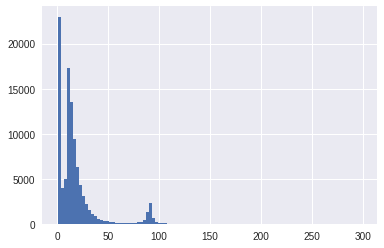

In [4]:
# So far we are only going to work with the invariant mass of the two muons.
# Let's plot it:
plt.hist(data.M, bins=100);

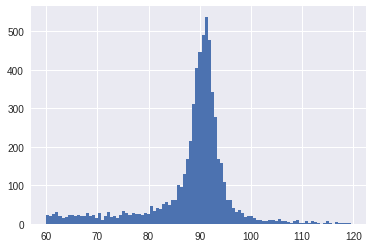

In [5]:
# Z-boson should be located somewhere in this range:
mass_range = (60., 120.)

data = data.loc[(data.M > mass_range[0]) & (data.M < mass_range[1])]
plt.hist(data.M, bins=100);

In [0]:
# Now, we'll do the same ML fit as we did before, using the same model

def SignalPDF(x, mass, sigma):
  return probfit.gaussian(x, mass, sigma)

def BgPDF(x, bg_slope):
  return bg_slope * np.exp(-bg_slope * x)

SignalPDF_n = probfit.Normalized(SignalPDF, mass_range)
BgPDF_n     = probfit.Normalized(BgPDF    , mass_range)

ModelPDF = probfit.AddPdfNorm(SignalPDF_n, BgPDF_n, facname=['fsig'])

In [0]:
likelihood = probfit.UnbinnedLH(ModelPDF, data.M.values)

In [8]:
print(iminuit.describe(likelihood))

['mass', 'sigma', 'bg_slope', 'fsig']


Now your turn to specify the initial parameter values, their limits and steps:

In [0]:
init_pars = dict(mass=90.,
                 sigma=5.,
                 bg_slope=1./60,
                 fsig=0.9)

par_limits = dict(limit_mass    =(80, 100),
                  limit_sigma   =( 2,  20),
                  limit_bg_slope=(1./500, 1./10),
                  limit_fsig    =(0.,  1.))

par_errors = dict(error_mass    =5.,
                  error_sigma   =1.,
                  error_bg_slope=0.05,
                  error_fsig    =0.05,
                 )

minuit = iminuit.Minuit(likelihood, **init_pars, **par_limits, **par_errors)

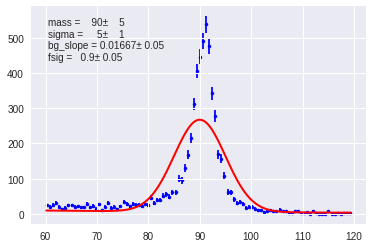

In [10]:
likelihood.draw(minuit=minuit);

In [11]:
minuit.migrad();

FCN = 19274.332167662906 
 TOTAL NCALL = 122 
 NCALLS = 122 
 
 
 EDM = 4.983867467212345e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mass,90.7161,0.0427106,,,80,100,No
1,sigma,2.50415,0.0436855,,,2,20,No
2,bg_slope,0.0288698,0.00166067,,,0.002,0.1,No
3,fsig,0.739409,0.00725663,,,0,1,No


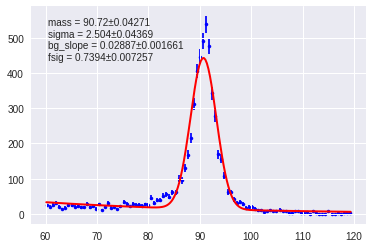

In [12]:
likelihood.draw(minuit=minuit);

It's easy to see that this fit is not perfect: our model does not seem to describe the data very well.
Any ideas how our model can be modified to improve this?

In [0]:
def sig1(x, mass, sigma, a, n):
  return probfit.crystalball(x, a, n, mass, sigma)
sig1 = probfit.Normalized(sig1, mass_range)

def sig2(x, mass, sigma, d_sigma):
  return probfit.gaussian(x, mass, sigma + d_sigma)
sig2 = probfit.Normalized(sig2, mass_range)

sig = probfit.AddPdfNorm(sig2, sig1, facname=['gaus_frac'])

def bg(x, bg_slope):
  return bg_slope * np.exp(-bg_slope * x)

bg = probfit.Normalized(bg, mass_range)

model_pdf = probfit.AddPdfNorm(sig, bg, facname=['fsig'])

In [14]:
likelihood = probfit.UnbinnedLH(model_pdf, data.M.values)
print(iminuit.describe(likelihood))

['mass', 'sigma', 'd_sigma', 'a', 'n', 'gaus_frac', 'bg_slope', 'fsig']


In [0]:
init_pars = dict(mass=90,
                 sigma=5,
                 d_sigma=15,
                 a=1.,
                 n=2.,
                 gaus_frac=0.2,
                 bg_slope=1./60,
                 fsig=0.9)

par_limits = dict(limit_mass=(80, 100),
                  limit_sigma=(1, 15),
                  limit_d_sigma=(1, 80),
                  limit_a=(0.05, 5),
                  limit_n=(0.1, 10.),
                  limit_gaus_frac=(0., 1.),
                  limit_bg_slope=(1./10000, 3./10),
                  limit_fsig=(0., 1.))

par_errors = dict(error_mass=5,
                  error_sigma=2,
                  error_d_sigma=10,
                  error_a=0.2,
                  error_n=0.5,
                  error_gaus_frac=0.1,
                  error_bg_slope=0.01,
                  error_fsig=0.05)

minuit = iminuit.Minuit(likelihood, **init_pars, **par_limits, **par_errors)

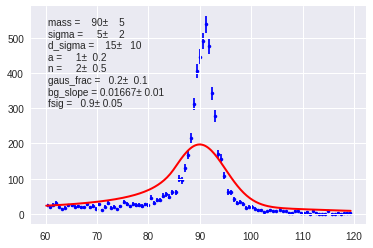

In [16]:
likelihood.draw(minuit=minuit);

In [17]:
minuit.migrad();

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SmallIntegralWarning: (89.9557, 90.84301235841058, 1.8328296203404941, 1.6975581199486824, 0.8918272835757358)
  """Entry point for launching an IPython kernel.


FCN = 19082.837455351015 
 TOTAL NCALL = 732 
 NCALLS = 732 
 
 
 EDM = 5.7397523390195875e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mass,90.8546,0.0445875,,,80,100,No
1,sigma,1.84957,0.0719601,,,1,15,No
2,d_sigma,3.60628,0.528537,,,1,80,No
3,a,1.6828,0.150861,,,0.05,5,No
4,n,1.0068,0.309454,,,0.1,10,No
5,gaus_frac,0.240204,0.0319816,,,0,1,No
6,bg_slope,0.0334204,0.00414197,,,0.0001,0.3,No
7,fsig,0.856943,0.014052,,,0,1,No


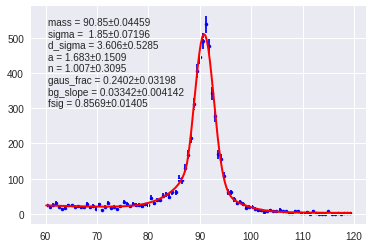

In [18]:
likelihood.draw(minuit=minuit);